## Data Preparation

In [1]:
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import numpy as np
from sklearn import linear_model
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder

In [2]:
train = pd.read_csv("train.csv",index_col=0)
test = pd.read_csv("test.csv",index_col=0)

## Split Train and Validation

In [3]:
X_train = train.drop("loss",axis=1)
Y_train = train['loss']
#kfolds = KFold(n = data_subset.shape[0],n_folds=5)
#X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, train_size=.75)

In [4]:
contFeatureslist = []
for colName,x in X_train.iloc[1,:].iteritems():
    if(not str(x).isalpha()):
        contFeatureslist.append(colName)

## Preselect some variables

In [5]:
X_train = X_train.drop(["cat89","cat92","cat96","cat99","cat103","cat106","cat109","cat110","cat113","cat116"],axis=1)
catFeatureslist = []
for colName,x in X_train.iloc[1,:].iteritems():
    if(str(x).isalpha()):
        catFeatureslist.append(colName)
from collections import defaultdict
d = defaultdict(LabelEncoder)
fit = X_train[catFeatureslist].apply(lambda x: d[x.name].fit_transform(x))
result = pd.concat([fit, X_train[contFeatureslist]], axis=1)
# for cf in catFeatureslist:
#     le = LabelEncoder()
#     le.fit(X_train[cf].unique())
#     X_train[cf] = le.transform(X_train[cf])
b = SelectKBest(f_regression, k=50)
b.fit(result, Y_train)
mask = b.get_support()
fit = fit.apply(lambda x: d[x.name].inverse_transform(x))
X_train = pd.concat([fit,X_train[contFeatureslist]],axis=1)
# for cf in catFeatureslist:
#     X_train[cf] = le.inverse_transform(X_train[cf])

AttributeError: 'DataFrame' object has no attribute 'X_train'

## Write a function to clean the data

In [11]:
def cleanTrainData(X,Y,mask):
    clean_Y = np.log1p(Y)
    clean_X = X[X.columns[mask]]
    catFeatureslist = []
    for colName in clean_X.columns:
        if(colName[0:3]=="cat"):
            catFeatureslist.append(colName)
    clean_X = pd.get_dummies(clean_X,columns = catFeatureslist,drop_first = True, sparse = True)
    contFeatureslist = []
    for colName in clean_X.columns:
        if(colName[0:4]=="cont"):
            contFeatureslist.append(colName)
    clean_X[contFeatureslist] = pd.DataFrame(preprocessing.scale(clean_X[contFeatureslist]),index = clean_X.index, columns = contFeatureslist)
    return clean_X,clean_Y   

In [12]:
X_train_new,Y_train_new = cleanTrainData(X_train,Y_train,mask)

In [13]:
def cleanTestData(X,mask):
    clean_X = X[X.columns[mask]]
    catFeatureslist = []
    for colName in clean_X.columns:
        if(colName[0:3]=="cat"):
            catFeatureslist.append(colName)
    clean_X = pd.get_dummies(clean_X,columns = catFeatureslist,drop_first = True, sparse = True)
    contFeatureslist = []
    for colName in clean_X.columns:
        if(colName[0:4]=="cont"):
            contFeatureslist.append(colName)
    clean_X[contFeatureslist] = pd.DataFrame(preprocessing.scale(clean_X[contFeatureslist]),index = clean_X.index, columns = contFeatureslist)
    return clean_X 

In [14]:
X_test = test.drop(["cat89","cat92","cat96","cat99","cat103","cat106","cat109","cat110","cat113","cat116"],axis=1)

X_test_new = cleanTestData(X_test,mask)

In [18]:
cols = X_train_new.columns.intersection(X_test_new.columns)

In [19]:

X_train_new = pd.DataFrame(X_train_new,columns=cols)
X_test_new = pd.DataFrame(X_test_new,columns=cols)

In [20]:
def LassoValMae(X_tr, Y_tr, k, cs):
    '''
    Perform k-fold cross validation on logistic regression, varies C and penalty Type (L1 or L2),
    returns a dictionary where key=c,value=[auc-c1, auc-c2, ...auc-ck].
    '''
    cv = KFold(n=X_tr.shape[0], n_folds = k)
    maes = {}

    for train_index, test_index in cv:
        X_tr_f = X_tr.iloc[train_index]
        X_va_f = X_tr.iloc[test_index]
        Y_tr_f = Y_tr.iloc[train_index]
        Y_va_f = Y_tr.iloc[test_index]
        
        for c in cs:
            lr = linear_model.Lasso(alpha=c)
            lr.fit(X_tr_f,Y_tr_f)
            met = mean_absolute_error(np.expm1(Y_va_f), np.expm1(lr.predict(X_va_f)))
            if c in maes:
                maes[c].append(met)
            else:
                maes[c] = [met]   
    return maes

In [21]:
k = 5
exp = range(-5,0)
cs = [10**i for i in exp]
maes = LassoValMae(X_train_new, Y_train_new, k, cs)

/home/peimengsui/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


In [22]:
xval_dict = {'e':[], 'mu':[], 'sig':[]}
for i in exp:
    xval_dict['e'].append(i)
    xval_dict['mu'].append(np.array(maes[10**i]).mean())
    xval_dict['sig'].append(np.sqrt(np.array(maes[10**i]).var()))
xvals = pd.DataFrame(xval_dict)
xvals['low'] = xvals['mu']-xvals['sig']/np.sqrt(k)
xvals['up'] = xvals['mu']+xvals['sig']/np.sqrt(k)
best = xvals[xvals['mu']==min(xvals['mu'])]
max_1std = np.array(best["mu"]-(best["sig"]/np.sqrt(k)))

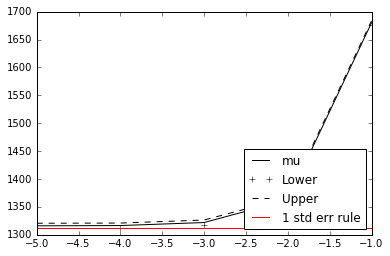

In [23]:
plt.clf()
plt.plot(xvals['e'], xvals['mu'], 'k')
plt.plot(xvals['e'], xvals['low'], 'k+', label='Lower')
plt.plot(xvals['e'], xvals['up'], 'k--',label='Upper')
plt.plot(xvals['e'], np.ones(len(exp))*max_1std, 'r', label ='1 std err rule')
plt.legend(loc=4)
plt.show()

In [24]:
best

,e,mu,sig,low,up
0,-5,1316.135717,10.22944,1311.560972,1320.710462


In [29]:
best_lasso = linear_model.Lasso(alpha=10**int(best["e"]))
best_lasso.fit(X_train_new,Y_train_new)

/home/peimengsui/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


Lasso(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [30]:
prediction = np.expm1(best_lasso.predict(X_test_new))

In [31]:
submit = pd.read_csv("sample_submission.csv")

In [32]:
submit["loss"] = prediction
submit.to_csv("lasso_template.csv",index=False)